
# Model training
- model?? choose 2-5 promising models for fine tuning
- metric??
    - F1 Score and ROC-AUC, confusion matrix?
    - Accuracy is a good measure in this round when 60% of the results are yes and 40% no, but it could change in the future when the dataset is less balanced.
    - F1 Score is good too because it is generally useful for unclear situations, aim for 0.6-0.7 with low standard deviaton
    - Confusion matrix could be used for diagnosis of the model error profile  
- fine tuning several models
  - from sklearn.neural_network import MLPClassifier
  - from sklearn.tree import DecisionTreeClassifier
  - from sklearn.ensemble import RandomForestClassifier
  - from sklearn.linear_model import LogisticRegression
  - from lightgbm import LGBMClassifier
  - Using Cross Validation with 3 folds to determine the best model and hyperparameters
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# ensure changes in files are reflected
%load_ext autoreload
%autoreload 2
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
# get data from preprocessed files
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
X_train_t = pd.read_csv("../data/processed/X_train_transform.csv")
X_test_t = pd.read_csv("../data/processed/X_test_transform.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()
numeric = ["AVERAGE TARGETED AFFORDABILITY", 'CDLAC TOTAL POINTS SCORE', 'CDLAC TIE-BREAKER SELF SCORE', "BOND REQUEST", "HOMELESS %"]
cat = ["CONSTRUCTION TYPE", "HOUSING TYPE", "CDLAC POOL", "NEW CONSTRUCTION SET ASIDE", "CDLAC REGION"]

In [3]:
X_train.describe()

,AVERAGE TARGETED AFFORDABILITY,CDLAC TOTAL POINTS SCORE,CDLAC TIE-BREAKER SELF SCORE,BOND REQUEST,HOMELESS %
count,68.000000,68.000000,68.000000,6.800000e+01,68.000000
mean,0.499822,116.073529,1.323691,3.749625e+07,0.109370
std,0.086210,5.596684,0.381380,2.074235e+07,0.274484
min,0.300000,90.000000,0.731959,7.325000e+06,0.000000
25%,0.423616,110.000000,1.045810,2.140221e+07,0.000000
50%,0.499315,119.000000,1.247946,3.307151e+07,0.000000
75%,0.597661,119.000000,1.548459,4.864018e+07,0.000000
max,0.600000,120.000000,2.360634,1.080000e+08,1.000000


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)
# pipelines
def binary_homeless(X):
    return (X > 0).astype(int)
homeless_transformer = FunctionTransformer(
    func=binary_homeless,
    feature_names_out="one-to-one",
)
homeless_pipe = make_pipeline(homeless_transformer)

points_transformer = PowerTransformer(method="yeo-johnson")
points_pipe = make_pipeline(points_transformer, MinMaxScaler())

cat_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
remainder_num_pipe = make_pipeline(StandardScaler())

preprocessor_pipe = ColumnTransformer(
    transformers=[
        ("homeless_binary", homeless_pipe, ["HOMELESS %"]),
        ("points_power", points_pipe, ["CDLAC TOTAL POINTS SCORE"]),
        ("category", cat_pipe, cat),
    ],
    remainder=remainder_num_pipe,
)

## Choosing a few random models and using default hyperparameters

In [5]:
from sklearn.ensemble import RandomForestClassifier
# just to create the graph of the full pipeline
full_pipeline = make_pipeline(preprocessor_pipe, RandomForestClassifier(random_state=42))
full_pipeline.fit(X_train, y_train)

/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('homeless_binary',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function binary_homeless at 0x758211a484c0>))]),
                                                  ['HOMELESS %']),
                                                 ('points_power',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['CDLAC TOTAL POINTS SCORE']),
                                                 ('category',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CONSTRUCTION TYPE',
                                                   'HOUSING TYPE', 'CDLAC POOL',
                                                   'NEW CONSTRUCTION SET ASIDE',
                                                   'CDLAC REGION'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [6]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(random_state=42, max_depth=2)
dtc_model.fit(X_train_t, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [7]:
y_train_pred = dtc_model.predict(X_train_t)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])

model predictions on train:  [0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]


In [8]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
def f1_scores_comparision(y_train_pred, model, X):
    train_f1 = f1_score(y_train, y_train_pred)
    print(f"Train             F1 score: {train_f1:.3f}")
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y_train, cv=cv, scoring='f1')
    print(f"Cross-validation F1 scores: {scores.mean():.3f} ± {scores.std():.3f}")

In [9]:
f1_scores_comparision(y_train_pred, dtc_model, X_train_t)

Train             F1 score: 0.727
Cross-validation F1 scores: 0.365 ± 0.155


In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(random_state=42, max_depth=2)
rfc_model.fit(X_train_t, y_train)

RandomForestClassifier(max_depth=2, random_state=42)

In [11]:
y_train_pred = rfc_model.predict(X_train_t)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, rfc_model, X_train_t)

model predictions on train:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 0.526
Cross-validation F1 scores: 0.301 ± 0.240


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train_t, y_train)

GradientBoostingClassifier(random_state=42)

In [13]:
y_train_pred = gbc_model.predict(X_train_t)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, gbc_model, X_train_t)

model predictions on train:  [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 1.000
Cross-validation F1 scores: 0.441 ± 0.135


In [14]:
from sklearn.linear_model import LogisticRegression
lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_t, y_train)

LogisticRegression(random_state=42)

In [15]:
y_train_pred = lg_model.predict(X_train_t)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, lg_model, X_train_t)

model predictions on train:  [0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 0.720
Cross-validation F1 scores: 0.475 ± 0.054


In [16]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(random_state=42)
mlp_model.fit(X_train_t, y_train)

/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [17]:
y_train_pred = mlp_model.predict(X_train_t)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, mlp_model, X_train_t)

/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


model predictions on train:  [0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 0.947
Cross-validation F1 scores: 0.463 ± 0.061


/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
import re

# Function to clean feature names
def clean_feature_names(columns):
    # Replace special characters with underscores and remove problematic ones
    cleaned = [re.sub(r'[^a-zA-Z0-9_]', '_', str(col)) for col in columns]
    # Ensure no duplicate names after cleaning
    seen = set()
    unique_columns = []
    for col in cleaned:
        new_col = col
        counter = 1
        while new_col in seen:
            new_col = f"{col}_{counter}"
            counter += 1
        unique_columns.append(new_col)
        seen.add(new_col)
    return unique_columns

# Clean the feature names
cleaned_columns = clean_feature_names(X_train_t.columns)
X_train_t_clean = pd.DataFrame(X_train_t)
X_train_t_clean.columns = cleaned_columns

In [19]:
from lightgbm import LGBMClassifier

# Define the LightGBM model with LightGBMLarge hyperparameters
lgbm_large = LGBMClassifier(
    learning_rate=0.03,
    num_leaves=128,
    feature_fraction=0.9,
    min_data_in_leaf=3,
    objective='binary',  # For binary classification
    random_state=42,    # For reproducibility
    verbose=-1          # Suppress LightGBM warnings
)

lgbm_large.fit(X_train_t_clean, y_train)

LGBMClassifier(feature_fraction=0.9, learning_rate=0.03, min_data_in_leaf=3,
               num_leaves=128, objective='binary', random_state=42, verbose=-1)

In [20]:
y_train_pred = lgbm_large.predict(X_train_t_clean)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, lgbm_large, X_train_t_clean)

model predictions on train:  [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 1.000
Cross-validation F1 scores: 0.522 ± 0.110


## Hyperparameter search

In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# just to create the graph of the full pipeline
full_pipeline = make_pipeline(preprocessor_pipe, RandomForestClassifier(random_state=42))

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 5, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV( full_pipeline, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train, y_train)
print(f"Best Validation F1 (CV): {grid_search.best_score_:.3f}")

Best Validation F1 (CV): 0.511


In [22]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.062208,0.000636,0.012265,0.000539,None,5,50,"{'randomforestclassifier__max_depth': None, 'r...",0.400000,0.588235,0.545455,0.511230,0.080567,1
21,0.065365,0.001458,0.012934,0.000525,10,5,50,"{'randomforestclassifier__max_depth': 10, 'ran...",0.400000,0.588235,0.545455,0.511230,0.080567,1
23,0.245240,0.020473,0.022084,0.002948,10,5,200,"{'randomforestclassifier__max_depth': 10, 'ran...",0.470588,0.666667,0.315789,0.484348,0.143575,3


In [23]:
grid_rfc = grid_search.best_estimator_

In [24]:
y_train_pred = grid_rfc.predict(X_train)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])

model predictions on train:  [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]


In [25]:
f1_scores_comparision(y_train_pred, grid_rfc, X_train)

Train             F1 score: 0.963
Cross-validation F1 scores: 0.511 ± 0.081


In [26]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
# just to create the graph of the full pipeline
full_pipeline = make_pipeline(preprocessor_pipe, RandomForestClassifier(random_state=42))
# Define parameter distributions
param_dist = {
    'randomforestclassifier__n_estimators': randint(50, 201),
    'randomforestclassifier__max_depth': [None] + list(range(1, 21)),
    'randomforestclassifier__min_samples_split': randint(2, 11)
}
# Randomized search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=150,  # Number of random combinations to try
    cv=cv,
    scoring='f1',
    random_state=42,  # For reproducible sampling
    verbose=1
)
random_search.fit(X_train, y_train)
print(f"Best Validation F1 (CV): {random_search.best_score_:.3f}")
print(f"Best Parameters: {random_search.best_params_}")

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Validation F1 (CV): 0.522
Best Parameters: {'randomforestclassifier__max_depth': 14, 'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__n_estimators': 70}


In [27]:
best_model_pipeline = random_search.best_estimator_
y_train_pred = best_model_pipeline.predict(X_train)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, best_model_pipeline, X_train)

model predictions on train:  [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 0.923
Cross-validation F1 scores: 0.522 ± 0.072


In [28]:
feature_importances = best_model_pipeline["randomforestclassifier"].feature_importances_
print(feature_importances)

[0.01563934 0.06939696 0.00331396 0.00327047 0.01035433 0.0227371
 0.00887113 0.02246028 0.00904913 0.01554308 0.02182905 0.03496454
 0.03479834 0.00537048 0.00781221 0.02629142 0.02082989 0.04027303
 0.02881383 0.02252161 0.06406478 0.01272267 0.03592207 0.1256678
 0.15655917 0.18092333]


In [29]:
sorted(zip(feature_importances, best_model_pipeline[-2].get_feature_names_out()), reverse=True)

[(np.float64(0.18092333392092683), 'remainder__BOND REQUEST'),
 (np.float64(0.15655916886384283), 'remainder__CDLAC TIE-BREAKER SELF SCORE'),
 (np.float64(0.1256678002719502), 'remainder__AVERAGE TARGETED AFFORDABILITY'),
 (np.float64(0.06939695806709373), 'points_power__CDLAC TOTAL POINTS SCORE'),
 (np.float64(0.06406477624183521),
  'category__CDLAC REGION_Coastal (Monterey, Napa, Orange, San Benito, San Diego, San Luis Obispo, Santa Barbara, Sonoma, and Ventura Counties) '),
 (np.float64(0.04027303020733739),
  'category__CDLAC REGION_Balance of Los Angeles County'),
 (np.float64(0.035922074442256986),
  'category__CDLAC REGION_Northern (Butte, El Dorado, Placer, Sacramento, San Joaquin, Shasta, Solano, Sutter, Yuba, and Yolo Counties)'),
 (np.float64(0.034964535128277206),
  'category__CDLAC POOL_Other Rehabilitation'),
 (np.float64(0.03479833828362865), 'category__CDLAC POOL_Preservation'),
 (np.float64(0.028813834112870865),
  'category__CDLAC REGION_Bay Area (Alameda, Contra Cos

In [30]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
# just to create the graph of the full pipeline
full_pipeline = make_pipeline(preprocessor_pipe, LogisticRegression(random_state=42))

# Define parameter distributions
param_dist = {
    'logisticregression__C': uniform(0.001, 1000),  # Continuous range for C
    'logisticregression__penalty': ['l1', 'l2'],    # Regularization types
    'logisticregression__solver': ['liblinear', 'saga', 'lbfgs'],  # Solvers
    'logisticregression__class_weight': [None, 'balanced'],  # Handle class imbalance
    'logisticregression__max_iter': [100, 200, 500]  # Iteration limits
}
# Randomized search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=150,  # Number of random combinations to try
    cv=cv,
    scoring='f1',
    random_state=42,  # For reproducible sampling
    verbose=1
)
random_search.fit(X_train, y_train)
print(f"Best Validation F1 (CV): {random_search.best_score_:.3f}")
print(f"Best Parameters: {random_search.best_params_}")

Fitting 3 folds for each of 150 candidates, totalling 450 fits


/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached w

Best Validation F1 (CV): 0.553
Best Parameters: {'logisticregression__C': np.float64(815.4624284548341), 'logisticregression__class_weight': None, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
81 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are mor

In [31]:
best_model_pipeline = random_search.best_estimator_
y_train_pred = best_model_pipeline.predict(X_train)
print("model predictions on train: ", y_train_pred[:20])
print("actual y values:            ", y_train[:20])
f1_scores_comparision(y_train_pred, best_model_pipeline, X_train)

model predictions on train:  [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0]
actual y values:             [0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1]
Train             F1 score: 0.786
Cross-validation F1 scores: 0.553 ± 0.038


In [36]:
prob = best_model_pipeline.predict_proba(X_train)
odds = prob / (1 - prob)
print(f"{odds:.3f}")

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [46]:
prob = best_model_pipeline.predict_proba(X_train)
yes_prob = prob[:, 1]
print(yes_prob)

[0.21310461 0.00179343 0.58545607 0.41510579 0.32197895 0.10368673
 0.12342268 0.00887916 0.83666183 0.58443115 0.09944974 0.5442954
 0.3688229  0.02339234 0.21406604 0.56028045 0.51775968 0.87277004
 0.93795508 0.24001685 0.62927084 0.30958187 0.72059042 0.70245399
 0.58314646 0.22420467 0.06373447 0.97087414 0.99999755 0.00315306
 0.46620447 0.5454111  0.21373596 0.09561552 0.99486236 0.02322187
 0.9461786  0.04723171 0.06017858 0.44749316 0.0250815  0.66896778
 0.52613615 0.99877616 0.04186177 0.78918796 0.0070079  0.43984737
 0.32475765 0.00134791 0.65719679 0.0599264  0.89577087 0.42353438
 0.99672769 0.01342685 0.99182873 0.99700484 0.00122625 0.00673306
 0.23404909 0.00251346 0.00803001 0.8791738  0.12699479 0.27819778
 0.44068934 0.54479968]


## Trying AutoML from Auto

In [82]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

In [83]:
# Assuming X_train and y_train are already loaded as provided
# Combine X_train and y_train
train_combined = X_train.copy()
train_combined['AWARD'] = y_train

# Save to CSV
output_path = "../data/processed/train.csv"
train_combined.to_csv(output_path, index=False)
print(f"Combined training data saved to {output_path}")

Combined training data saved to ../data/processed/train.csv


In [6]:
# Assuming X_train and y_train are already loaded as provided
# Combine X_train and y_train
test_combined = X_test.copy()
test_combined['AWARD'] = y_test

# Save to CSV
output_path = "../data/processed/test.csv"
test_combined.to_csv(output_path, index=False)
print(f"Combined test data saved to {output_path}")

Combined test data saved to ../data/processed/test.csv


In [90]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label="AWARD", eval_metric="f1").fit("../data/processed/train.csv")

No path specified. Models will be saved in: "AutogluonModels/ag-20250620_152528"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun  5 18:30:46 UTC 2025
CPU Count:          8
Memory Avail:       0.31 GB / 1.86 GB (16.5%)
Disk Space Avail:   918.30 GB / 1006.85 GB (91.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competition

from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label="AWARD", eval_metric="f1").fit("../data/processed/train.csv")

## Results
- Default Decision Tree
  - Train             F1 score: 0.727
  - Cross-validation F1 scores: 0.365 ± 0.155
- Default Random Forest
  - Train             F1 score: 0.526
  - Cross-validation F1 scores: 0.301 ± 0.240
- Default GradientBoosting
  - Train             F1 score: 1.000
  - Cross-validation F1 scores: 0.441 ± 0.135 
- Default MLP
  - Train             F1 score: 0.947
  - Cross-validation F1 scores: 0.463 ± 0.061
- Default LogisticRegression has a score of:
  - Train             F1 score: 0.720
  - Cross-validation F1 scores: 0.475 ± 0.054
- RandomForestClassifier with grid search and random search tuning
  - Train             F1 score: 0.923
  - Cross-validation F1 scores: 0.522 ± 0.072
- LogisticRegression with random search tuning
  - Train             F1 score: 0.786
  - Cross-validation F1 scores: 0.553 ± 0.038
- LGBMClassifier, suggested by AutoGluon:
  - Train             F1 score: 0.982
  - Cross-validation F1 scores: 0.522 ± 0.110
- many of the complex models have higher train scores but are obviously overfitted
- The best generalised model seems to be the LogisticRegression fine tuned with random search
  -  Best Parameters: {'logisticregression__C': np.float64(815.4624284548341), 'logisticregression__class_weight': None, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
  -  Test F1 score: 0.78!!!

In [61]:
y_test_pred = best_model_pipeline.predict(X_test)
print("model predictions on train: ", y_test_pred[:20])
print("actual y values:            ", y_test[:20])

model predictions on train:  [1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0]
actual y values:             [1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0]


In [63]:
f1_score(y_test, y_test_pred)

0.782608695652174

In [64]:
print(random_search.best_params_)

{'logisticregression__C': np.float64(815.4624284548341), 'logisticregression__class_weight': None, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.69      0.90      0.78        10

    accuracy                           0.78        23
   macro avg       0.80      0.80      0.78        23
weighted avg       0.81      0.78      0.78        23



In [72]:
model = random_search.best_estimator_.named_steps['logisticregression']
feature_names = random_search.best_estimator_[-2].get_feature_names_out()
coefficients = pd.DataFrame(model.coef_[0], index=feature_names, columns=['Coefficient'])
print(coefficients.sort_values(by='Coefficient', ascending=False))

                                                    Coefficient
category__HOUSING TYPE_At-Risk                         7.585839
points_power__CDLAC TOTAL POINTS SCORE                 7.392798
category__CDLAC POOL_Preservation                      5.871947
category__CDLAC REGION_Balance of Los Angeles C...     2.586625
remainder__CDLAC TIE-BREAKER SELF SCORE                1.924480
category__CDLAC REGION_Northern (Butte, El Dora...     1.450027
homeless_binary__HOMELESS %                            0.856538
category__NEW CONSTRUCTION SET ASIDE_Homeless, ...     0.369292
category__CONSTRUCTION TYPE_New Construction           0.000000
category__CONSTRUCTION TYPE_Acq and Rehabilitation     0.000000
category__HOUSING TYPE_Large Family                    0.000000
category__CDLAC REGION_Inland (Fresno, Imperial...     0.000000
category__CDLAC POOL_New Construction                  0.000000
remainder__AVERAGE TARGETED AFFORDABILITY             -0.185433
category__CDLAC POOL_Other Rehabilitatio

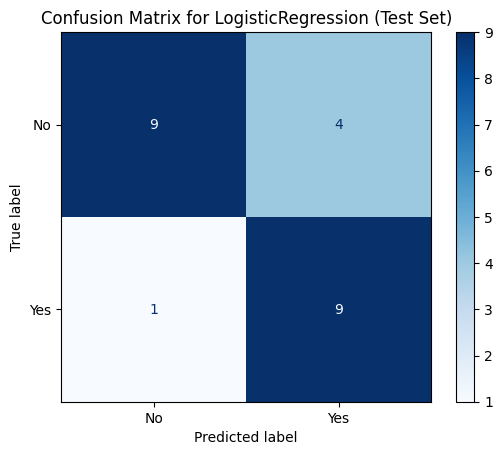

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LogisticRegression (Test Set)')
plt.show()

## Inference

In [4]:
import joblib

model_path = "../models/model.pkl"
preprocessor_path = "../models/preprocessor.pkl"
model = joblib.load(model_path)
preprocessor = joblib.load(preprocessor_path)

base_vector = pd.DataFrame({
    'avg_targeted_affordability': [0.6], # Given
    'CDLAC_total_points_score': [120], # Given
    'CDLAC_tie_breaker_self_score': [1.0],  # Given
    'bond_request_amount': [24000000], # Given
    'homeless_percent': [0.0],  # Median
    'construction_type': ['New Construction'], # most common type
    'housing_type': ['Large Family'], # most common type
    'CDLAC_pool_type': ['New Construction'], # most common type
    'new_construction_set_aside': ['none'], # most common type
    'CDLAC_region': ['City of Los Angeles'], # Given
})
optimistic_vector = pd.DataFrame({
    'avg_targeted_affordability': [0.5021], # Assume median
    'CDLAC_total_points_score': [120], # Given
    'CDLAC_tie_breaker_self_score': [2.0],  # High
    'bond_request_amount': [37640000], # Median
    'homeless_percent': [0.5],  # High
    'construction_type': ['New Construction'], # most common type
    'housing_type': ['At-Risk'], # Good housing type for awards
    'CDLAC_pool_type': ['Preservation'], # Good Pool to be in
    'new_construction_set_aside': ['none'], # most common type
    'CDLAC_region': ['City of Los Angeles'], # Given
})

transformed_base = preprocessor.transform(base_vector)
trasnformed_optimisitc = preprocessor.transform(optimistic_vector)
base_prob = model.predict_proba(transformed_base)[:, 1][0]
optimistic_prob = model.predict_proba(trasnformed_optimisitc)[:, 1][0]

# Convert to odds
base_odds = base_prob / (1 - base_prob)
optimistic_odds = optimistic_prob / (1 - optimistic_prob)

print(f"Base Scenario Probability (AWARD=Yes): {base_prob:.3f}")
print(f"Base Scenario Odds: {base_odds:.3f}:1")
print(f"Optimistic Scenario Probability (AWARD=Yes): {optimistic_prob:.9f}")
print(f"Optimistic Scenario Odds: {optimistic_odds:.3f}:1")

Base Scenario Probability (AWARD=Yes): 0.581
Base Scenario Odds: 1.385:1
Optimistic Scenario Probability (AWARD=Yes): 0.999999995
Optimistic Scenario Odds: 218850570.172:1


/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle 

/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dsfee222/.virtualenvs/affordable_housing/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle 

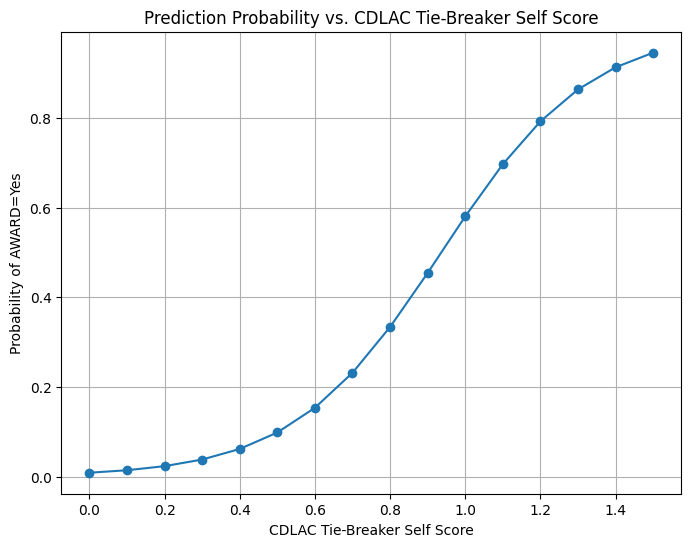

In [5]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load model and preprocessor
model_path = "../models/model.pkl"
preprocessor_path = "../models/preprocessor.pkl"
model = joblib.load(model_path)
preprocessor = joblib.load(preprocessor_path)

# Base vector with fixed features
base_vector = pd.DataFrame({
    'avg_targeted_affordability': [0.6],  # Given
    'CDLAC_total_points_score': [120],  # Given
    'CDLAC_tie_breaker_self_score': [0.0],  # Placeholder, will be varied
    'bond_request_amount': [24000000],  # Given
    'homeless_percent': [0.0],  # Median
    'construction_type': ['New Construction'],  # Most common type
    'housing_type': ['Large Family'],  # Most common type
    'CDLAC_pool_type': ['New Construction'],  # Most common type
    'new_construction_set_aside': ['none'],  # Most common type
    'CDLAC_region': ['City of Los Angeles'],  # Given
})

# Vary CDLAC_tie_breaker_self_score from 0 to 1.5 in steps of 0.1
self_scores = np.arange(0, 1.6, 0.1)  # Include 1.5
probabilities = []

# Compute prediction probability for each self-score
for score in self_scores:
    # Update the self-score in the base vector
    base_vector['CDLAC_tie_breaker_self_score'] = [score]
    # Transform the input using the preprocessor
    transformed_vector = preprocessor.transform(base_vector)
    # Get the probability of AWARD=Yes (class 1)
    prob = model.predict_proba(transformed_vector)[:, 1][0]
    probabilities.append(prob)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(self_scores, probabilities, marker='o')
plt.xlabel('CDLAC Tie-Breaker Self Score')
plt.ylabel('Probability of AWARD=Yes')
plt.title('Prediction Probability vs. CDLAC Tie-Breaker Self Score')
plt.grid(True)
plt.show()